<a href="https://colab.research.google.com/github/beulah-s/Cell_counting_Group1/blob/main/cellcount.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from PIL import Image
from torch.utils.data import Dataset


In [ ]:
data_root = '/content/drive/MyDrive/CellCounts/IDCIA v2/images'
print('The num of images is', len(os.listdir(data_root)))

The num of images is 250


In [ ]:
class CellDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.tiff')]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        return image


def plot_cell(dataset, sample_id):
    """Displays the image corresponding to the sample ID"""
    image = dataset[sample_id]
    image = image.numpy().transpose((1, 2, 0))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

def compute_statistics(dataset):
    """Computes statistics (mean, std, median, min, max) for the dataset"""
    all_images = torch.stack([dataset[i] for i in range(len(dataset))])

    mean = all_images.mean()
    std = all_images.std()
    median = torch.median(all_images)
    min_val = all_images.min()
    max_val = all_images.max()

    return mean, std, median, min_val, max_val

def plot_dataset_info(dataset):
    """Visualizes some basic info of the dataset"""
    means, stds, medians, mins, maxs = [], [], [], [], []
    for i in range(len(dataset)):
        img = dataset[i]
        means.append(img.mean().item())
        stds.append(img.std().item())
        medians.append(torch.median(img).item())
        mins.append(img.min().item())
        maxs.append(img.max().item())

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(means, label='Mean')
    plt.plot(stds, label='Std')
    plt.plot(medians, label='Median')
    plt.plot(mins, label='Min')
    plt.plot(maxs, label='Max')
    plt.legend()
    plt.title('Dataset Info')
    plt.xlabel('Sample ID')
    plt.ylabel('Value')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def compute_labels(nums):
    """Computes statistics (mean, std, median, min, max) for the given list of numbers"""
    mean = np.mean(nums)
    std = np.std(nums)
    median = np.median(nums)
    min_val = np.min(nums)
    max_val = np.max(nums)

    return mean, std, median, min_val, max_val



In [ ]:
# Transform tiff format into torch tensor
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Construct the dataset
dataset = CellDataset(root_dir=data_root, transform=transform)


torch.Size([1, 600, 800])


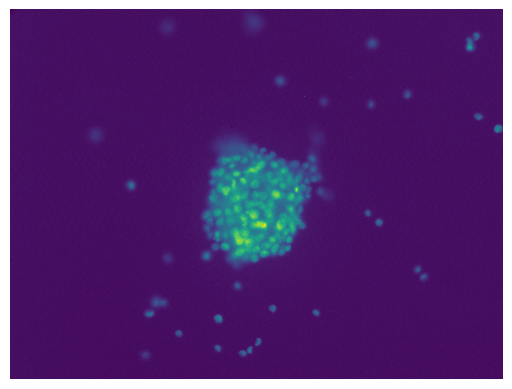

check the pixel value (brightness) of each photo
Mean: 0.041, Std: 0.032, Median: 0.035, Min: 0.000, Max: 0.773


In [ ]:
first_img = dataset[0]
print(first_img.shape)
# Plot a specific img (the example plot the first one)
plot_cell(dataset, 0)

# To compute and print statistics of the dataset:
mean, std, median, min_val, max_val = compute_statistics(dataset)
#mean, std, median, min_val, max_val = compute_statistics(testset)
print('check the pixel value (brightness) of each photo')
print(f'Mean: {mean:.3f}, Std: {std:.3f}, Median: {median:.3f}, Min: {min_val:.3f}, Max: {max_val:.3f}')

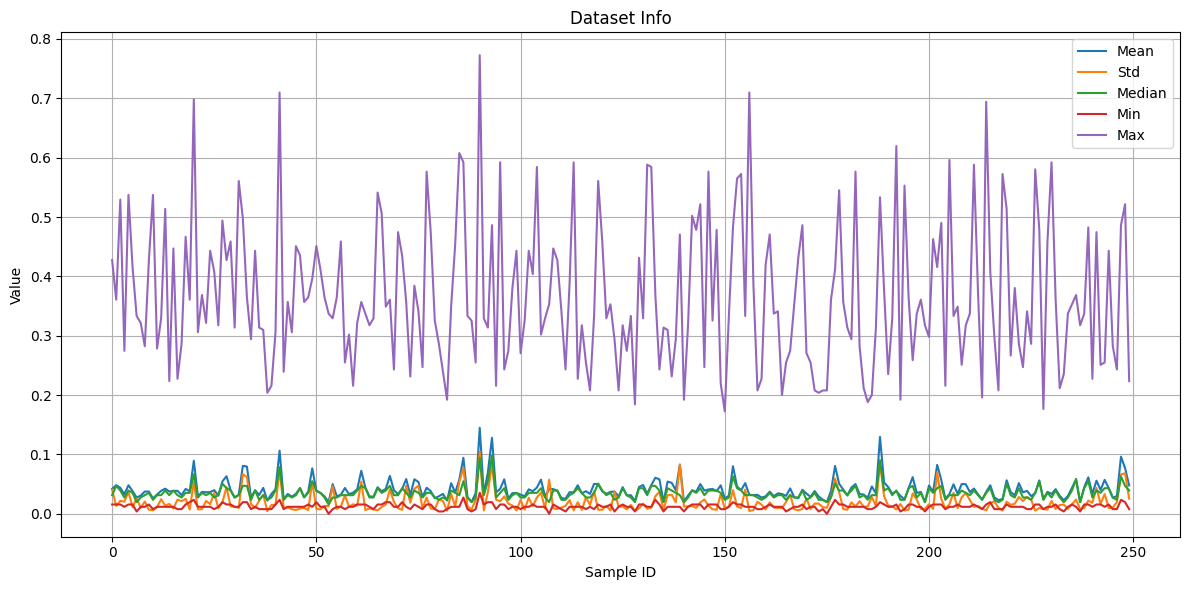

In [ ]:
plot_dataset_info(dataset)

<Figure size 1000x500 with 0 Axes>

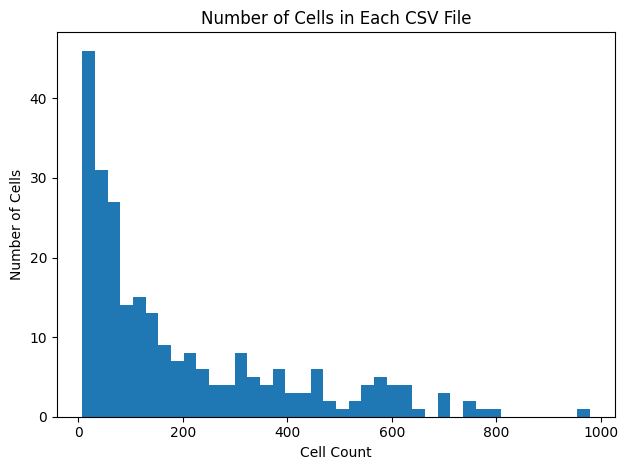

In [ ]:
label_path = '/content/drive/MyDrive/CellCounts/IDCIA v2/ground_truth'
all_files = os.listdir(label_path)
csv_files = [f for f in all_files if f.endswith('.csv')]

results = []

for csv_file in csv_files:
    csv_path = os.path.join(label_path, csv_file)
    df = pd.read_csv(csv_path)
    num_cells = df.shape[0]  # Number of cells
    results.append(num_cells)

results_df = pd.DataFrame(results, columns=['num_cells'])

plt.figure(figsize=(10, 5))
results_df.plot.hist(bins=40, legend=False)
plt.title('Number of Cells in Each CSV File')
plt.ylabel('Number of Cells')
plt.xlabel('Cell Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
# calculate the statistics of labels (num of cells)
mean, std, median, min_val, max_val = compute_labels(results_df['num_cells'][150:220])
print('check the statistics of num of cells')
print(f"Mean: {mean:.3f}, Std: {std:.3f}, Median: {median:.3f}, Min: {min_val:.3f}, Max: {max_val:.3f}")


check the statistics of num of cells
Mean: 190.971, Std: 193.818, Median: 122.500, Min: 9.000, Max: 770.000


In [ ]:
from sklearn.model_selection import train_test_split

test_percent = 0.3
trainset, testset = train_test_split(dataset, test_size=test_percent, random_state=42)

print(len(trainset))
print(len(testset))

175
75


In [ ]:
num_low = 100  #lower bound of cell num
num_high = 200  #upper bound of cell num

selected_indices = [i for i, count in enumerate(results_df['num_cells']) if num_low <= count <= num_high]
testset_specific = torch.utils.data.Subset(dataset, selected_indices)

remaining_indices = [i for i in range(len(dataset)) if i not in selected_indices]
trainset_specific = torch.utils.data.Subset(dataset, remaining_indices)
# chec the length of  dataset with specified range
print(len(selected_indices))
print(len(remaining_indices))


47
203


In [ ]:
# 1 the code in the last cell can check how many data in a specific range
# 2 Implemented two ways of split (random split + specified split) specified split means we can get a test set that contain a specific range of num of cells
# 3 Risk: class (num) balance
# 4 We would like to use Accuracy and Mean Square Error (MSE) as metric currently. We may design data-specific metric in later stage.
# Current conclusion: the data set has limited labeled data, unbalanced labels (num of cells), and differnet data quality (blur level) Those challenges are reflected in the plots.
# Next step: we will tackle the challenges above and design advanced methodologies.

To get the total number of images for each antibody, field number and condition

In [ ]:
import pandas as pd
import numpy as np
import glob

In [ ]:
# path = '/content/drive/MyDrive/CellCounts/IDCIA v2/images'
# files = glob.glob(path + '*/*.tiff')

# files
# all = pd.DataFrame(files, columns=['file_path'])
# all.head()

In [ ]:
# def splitbyunderscore1(x):
  # return x.split("_")[-5]
# all['antibody']= all['file_path'].apply(splitbyunderscore1)
# all.head()

In [ ]:
# def splitbyunderscore2(x):
  # return x.split("_")[-4]
# all['fieldnumber'] = all['file_path'].apply(splitbyunderscore2)
# all.head()

In [ ]:
# def splitbyunderscore3(x):
  # return x.split("_")[-6]
# all['condition'] = all['file_path'].apply(splitbyunderscore3)
# all.head()

In [ ]:
# antibody = pd.DataFrame(all.groupby('antibody').size(), columns=['images'])
# antibody

In [ ]:
# fieldnumber = pd.DataFrame(all.groupby('fieldnumber').size(), columns=['images'])
# fieldnumber